<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/05_stable_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook
!pip install datasets

In [ ]:
import datasets
import diffusers
import transformers
import huggingface_hub

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision

from diffusers import DDPMPipeline
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionInpaintPipeline

from datasets import load_dataset

from genaibook.core import get_device
from genaibook.core import plot_noise_and_denoise
from genaibook.core import show_images
from genaibook.core import load_image, SampleURL
from genaibook.core import plot_scheduler
from genaibook.core import load_image, show_image, SampleURL

import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
transformers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

In [4]:
device = get_device()

## Dataset

In [ ]:
fashion_mnist = load_dataset("fashion_mnist")

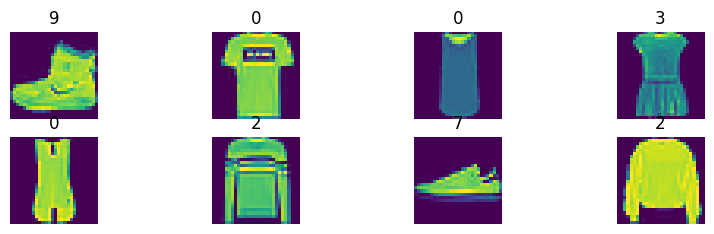

In [6]:
clothes = fashion_mnist["train"]["image"][:8]
classes = fashion_mnist["train"]["label"][:8]

show_images(clothes, titles=classes, figsize=(10, 2.5))

In [7]:
# Define transformations
preprocess = transforms.Compose(
   [
      transforms.RandomHorizontalFlip(),            # Randomly flip (data augmentation)
      transforms.ToTensor(),                        # Convert to tensor (0, 1)
      transforms.Pad(2),                            # Add 2 pixels on all sides
      transforms.Normalize([0.5], [0.5]),           # Map to (-1, 1)
   ]
)

In [8]:
def transform(examples):
  images = [preprocess(image) for image in examples["image"]]
  return {"images": images, "labels": examples["label"]}

train_dataset = fashion_mnist["train"].with_transform(transform)

In [9]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

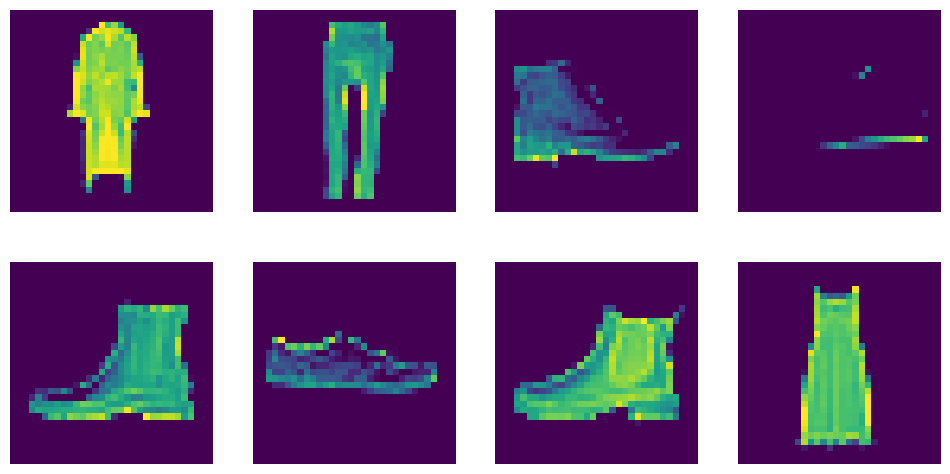

In [10]:
# let's load a batch and inspecting the images
batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
show_images((batch["images"][:8] * 0.5 * 0.5).clip(0, 1))

##Class-Conditioned Model

In [11]:
# let's create a UNet and feed our batch of noisy images through it
model = UNet2DModel(
    sample_size=32, # Specify our input size
    in_channels=1,  # 1 channel for grayscale images
    out_channels=1, # 1 channel for grayscale images
    block_out_channels=(32, 64, 128, 256), # How many channels each block will have
    num_class_embeds=10, # Enable class conditioning
)

In [12]:
# Pass a batch of data and the class labels as additional through to make sure it works
x = torch.randn((1, 1, 32, 32))
with torch.inference_mode():
  output = model(x, timestep=7, class_labels=torch.tensor([2])).sample
print(output.shape)

torch.Size([1, 1, 32, 32])


###Training

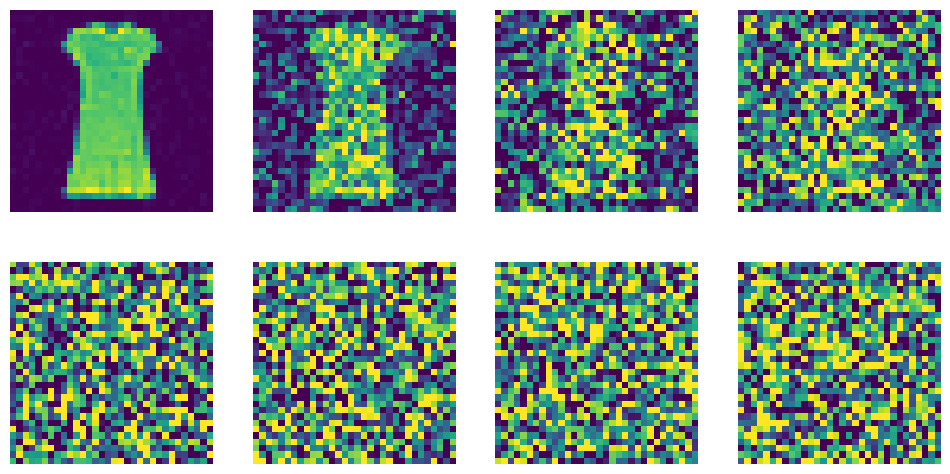

In [ ]:
# Initialize the scheduler
scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.001,
    beta_end=0.02,
)

# Sample a random timestep for each image
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

# We load 8 images from the dataset and add increasing amounts of noise to them
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.randn_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [ ]:
num_epochs = 25 # How many runs through the data should we do?
lr = 3e-4       # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []     # Somewhere to store the loss values for later plotting

model = model.to(device)

# Train the model (this takes a while)
for epoch in (progress := tqdm(range(num_epochs))):
  for step, batch in (inner := tqdm(enumerate(train_dataloader), position=0, leave=True, total=len(train_dataloader))):
    # Load the input images
    clean_images = batch["images"].to(device)
    class_lebels = batch["labels"].to(device)

    # Sample noise to add to the images
    noise = torch.randn(clean_images.shape).to(device)

    # Sample a random timestep for each image
    timesteps = torch.randint(
        0,
        scheduler.config.num_train_timesteps,
        (clean_images.shape[0],),
        device=device,
    ).long()

    # Add noise to the clean images according to the noise magnitude at each timestep
    noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

    # Get the model prediction for the noise
    # The model also uses the timestep as an input for additional conditioning
    # Note the use of class_labels
    noise_pred = model(noisy_images, timesteps, class_labels=class_lebels, return_dict=False)[0]

    # Compare the prediction with the actual noise
    loss = F.mse_loss(noise_pred, noise)

    # Update loss display
    inner.set_postfix(loss=f"{loss.cpu().item():03f}")

    # Store the loss for later plotting
    losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

 58%|█████▊    | 137/235 [01:35<01:08,  1.43it/s, loss=0.023526]

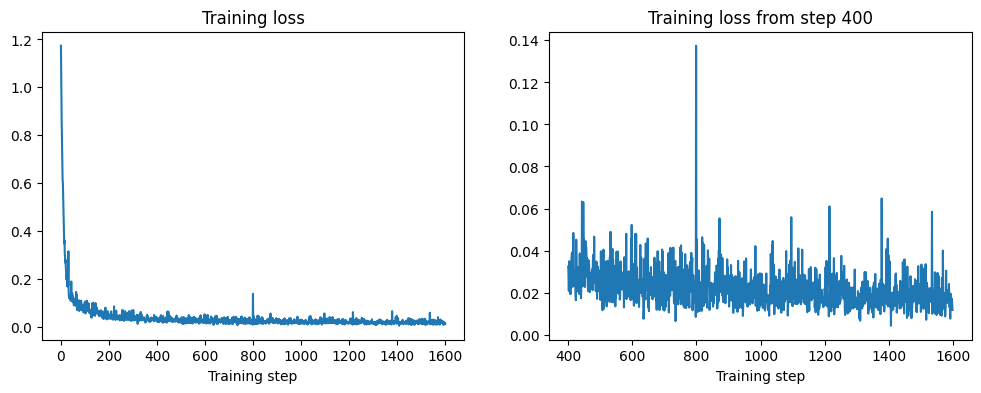

In [ ]:
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step");

###Sampling

We now have a model that expects two inputs when making predictions:

1. the image
2. the class label

  0%|          | 0/1000 [00:00<?, ?it/s]

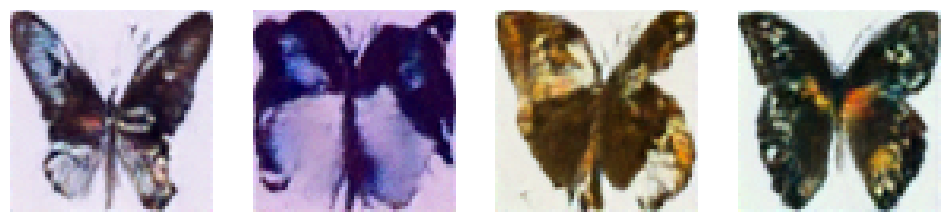

In [ ]:
def generate_from_class(class_to_generate, n_samples=8):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        # Get model prediction
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        # Update sample with step
        sample = scheduler.step(noise_pred, t, sample).prev_sample

    return sample.clip(-1, 1) * 0.5 + 0.5

# let’s do inference and generate some t-shirts (class 0)
images = generate_from_class(0)
show_images(images, nrows=2)

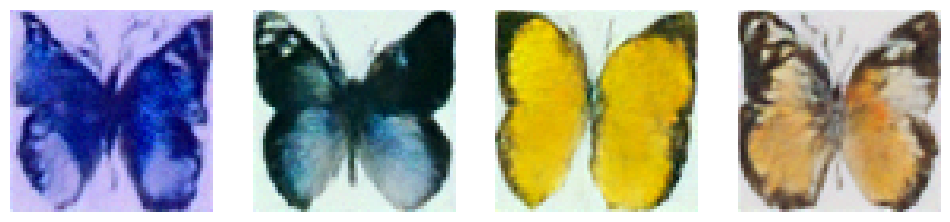

In [ ]:
# let’s generate some sneakers (class 7)
images = generate_from_class(7)
show_images(images, nrows=2)

In [ ]:
# let’s generate some boots (class 9)
images = generate_from_class(7)
show_images(images, nrows=2)

In [ ]:
# let’s generate some frock (class 3)
images = generate_from_class(3)
show_images(images, nrows=2)

##Stable Diffusion: Components in Depth

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

In [ ]:
pipe("Watercolor illustration of a rose").images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

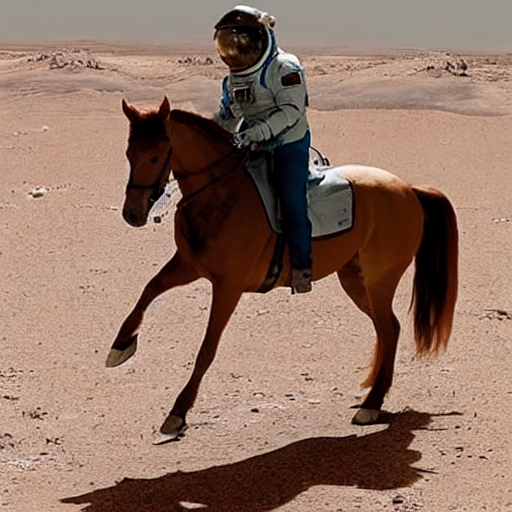

In [ ]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
image

In [ ]:

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

In [ ]:
!wget https://machinelearningmastery.com/wp-content/uploads/2024/04/inpaint-example.png
!wget https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png

In [ ]:
image = Image.open("inpaint-example.png").convert("RGB")
mask_image = Image.open("overture-creations-5sI6fQgYIuo_mask.png")

  0%|          | 0/50 [00:00<?, ?it/s]

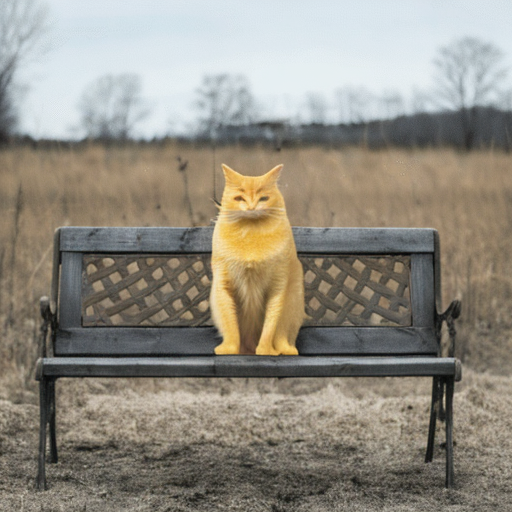

In [ ]:
prompt = "Face of a yellow cat, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
image

###Text Encoder

In [14]:
prompt = "A photograph of a puppy"

# Turn the text into a sequence of tokens
text_input = pipe.tokenizer(
    prompt,
    return_tensors="pt",
)

# Output each token and its corresponding ID
for t in text_input["input_ids"][0]:
    print(f"{t}: {pipe.tokenizer.decoder.get(int(t))}")

49406: <|startoftext|>
320: a</w>
8853: photograph</w>
539: of</w>
320: a</w>
6829: puppy</w>
49407: <|endoftext|>


In [15]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
print(f"Text embeddings shape: {text_embeddings.shape}")

Text embeddings shape: torch.Size([1, 7, 768])


###Variational AutoEncoder

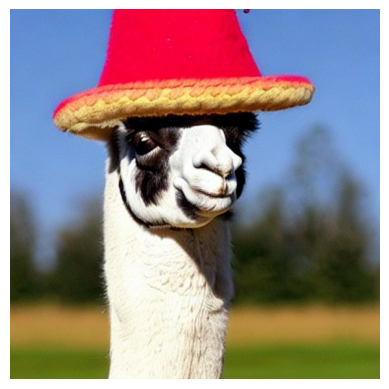

In [16]:
img = load_image(SampleURL.LlamaExample, size=(512, 512))
show_image(img);

In [18]:
with torch.inference_mode():
  # Process image
  tensor_im = transforms.ToTensor()(img).unsqueeze(0).to(device) * 2 - 1
  tensor_im = tensor_im.half() # convert from float32 to float16

  # Encode image
  latent = pipe.vae.encode(tensor_im)

  # Sample from the latent distribution
  latents = latent.latent_dist.sample()
  latents = latents * 0.18215 # Scale the latent vector
print(latents.shape)

torch.Size([1, 4, 64, 64])


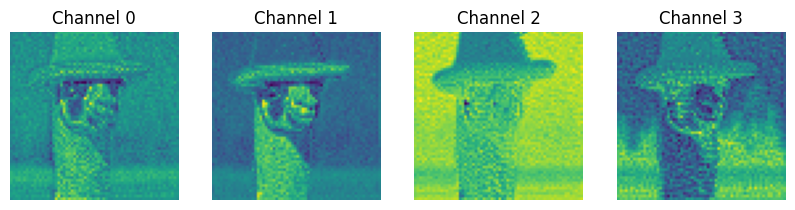

In [22]:
show_images(
    [l.cpu() for l in latents[0]],
    titles=[f"Channel {i}" for i in range(latents.shape[1])],
    ncols=4,
    figsize=(10, 2.5)
)

<Axes: >

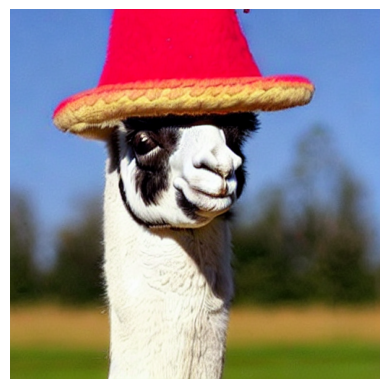

In [24]:
with torch.inference_mode():
  # Decode the latent image
  image = pipe.vae.decode(latents / 0.18215).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float())

### UNet model